##Without Residual Blocks

In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Split trainset into train and validation
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [93]:

# Define the model
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  #depthwise convolution
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=1, padding=0),  #pointwise convolution
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  #depthwise convolution
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=1, padding=0),  #pointwise convolution
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  #depthwise convolution
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=1, padding=0),  #pointwise convolution
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  #depthwise convolution
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=1, padding=0),  #pointwise convolution
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(16384, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 100)
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.99))

Epoch [1/10], Train Loss: 3.4089, Train Accuracy: 18.66%, Val Loss: 3.0048, Val Accuracy: 26.23%
Epoch [2/10], Train Loss: 2.5262, Train Accuracy: 34.82%, Val Loss: 2.5241, Val Accuracy: 35.03%
Epoch [3/10], Train Loss: 2.0768, Train Accuracy: 44.25%, Val Loss: 2.3954, Val Accuracy: 38.69%
Epoch [4/10], Train Loss: 1.7476, Train Accuracy: 51.96%, Val Loss: 2.3531, Val Accuracy: 41.09%
Epoch [5/10], Train Loss: 1.4282, Train Accuracy: 59.69%, Val Loss: 2.1836, Val Accuracy: 45.09%
Epoch [6/10], Train Loss: 1.1344, Train Accuracy: 67.03%, Val Loss: 2.3164, Val Accuracy: 43.57%
Epoch [7/10], Train Loss: 0.8680, Train Accuracy: 74.31%, Val Loss: 2.3563, Val Accuracy: 44.89%
Epoch [8/10], Train Loss: 0.6171, Train Accuracy: 81.29%, Val Loss: 2.4956, Val Accuracy: 45.06%
Epoch [9/10], Train Loss: 0.4268, Train Accuracy: 87.18%, Val Loss: 2.7257, Val Accuracy: 44.75%
Epoch [10/10], Train Loss: 0.3118, Train Accuracy: 90.47%, Val Loss: 2.9149, Val Accuracy: 45.30%
Finished Training
Test Loss: 

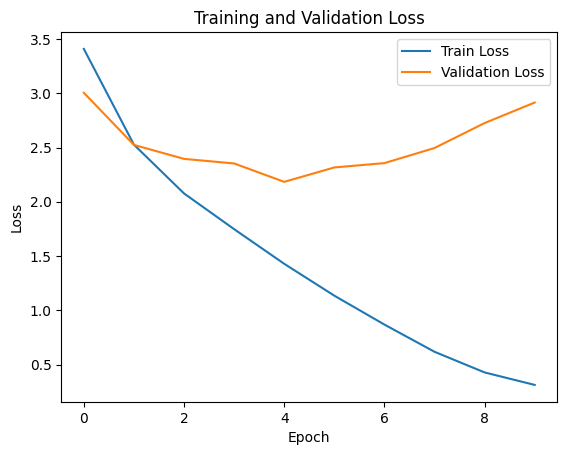

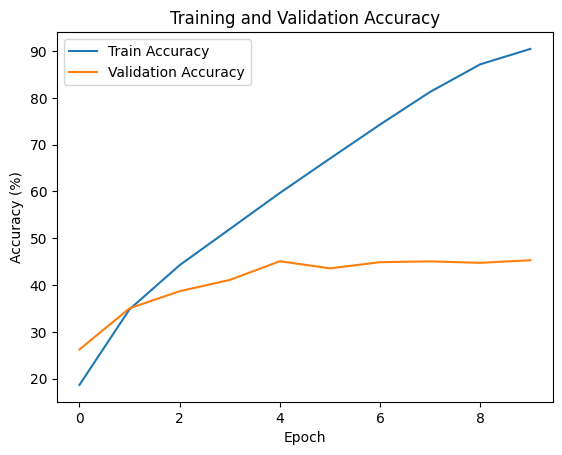

In [94]:
# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Train the model
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(trainloader)
    epoch_train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(valloader)
    epoch_val_accuracy = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%, '
          f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.2f}%')

print('Finished Training')

# Test the model
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Calculate test accuracy
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_loss /= len(testloader)
test_accuracy = 100 * correct_test / total_test

print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss, test_accuracy))

# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot accuracy curves
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [95]:
# Evaluate the model
model.eval()
y_true = []
y_pred_classes = []

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred_classes.extend(predicted.cpu().numpy())

# Calculate evaluation metrics
import numpy as np
y_true = np.array(y_true)
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
f1 = f1_score(y_true, y_pred_classes, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.4447
Precision: 0.4678365063396246
Recall: 0.44470000000000004
F1 Score: 0.4439692765716943


##After adding Residual Blocks

In [100]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Define the residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)  #depthwise convolution
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=1, padding=0)  #pointwise convolution
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual  # Add residual
        out = self.relu(out)
        return out

# Define the model
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            ResidualBlock(32, 32),  # Residual block 1
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            ResidualBlock(64, 64),  # Residual block 2
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  #depthwise convolution
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=1, padding=0),  #pointwise convolution
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  #depthwise convolution
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=1, padding=0),  #pointwise convolution
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 2 * 2, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 100)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model
model = CustomCNN().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99))


Epoch [1/10], Train Loss: 3.6278, Train Accuracy: 13.69%, Val Loss: 3.1050, Val Accuracy: 22.10%
Epoch [2/10], Train Loss: 2.7737, Train Accuracy: 28.57%, Val Loss: 2.7709, Val Accuracy: 28.89%
Epoch [3/10], Train Loss: 2.3336, Train Accuracy: 37.35%, Val Loss: 2.4406, Val Accuracy: 36.48%
Epoch [4/10], Train Loss: 2.0364, Train Accuracy: 44.47%, Val Loss: 2.2945, Val Accuracy: 39.93%
Epoch [5/10], Train Loss: 1.8008, Train Accuracy: 49.77%, Val Loss: 2.2060, Val Accuracy: 42.55%
Epoch [6/10], Train Loss: 1.5939, Train Accuracy: 54.31%, Val Loss: 2.0683, Val Accuracy: 45.40%
Epoch [7/10], Train Loss: 1.4172, Train Accuracy: 58.88%, Val Loss: 2.0555, Val Accuracy: 46.34%
Epoch [8/10], Train Loss: 1.2324, Train Accuracy: 63.37%, Val Loss: 2.1003, Val Accuracy: 46.58%
Epoch [9/10], Train Loss: 1.0706, Train Accuracy: 67.66%, Val Loss: 2.1550, Val Accuracy: 48.42%
Epoch [10/10], Train Loss: 0.9218, Train Accuracy: 71.55%, Val Loss: 2.2569, Val Accuracy: 46.78%
Finished Training
Test Loss: 

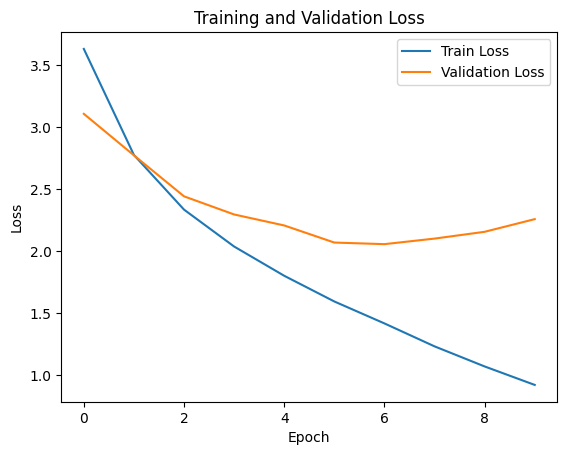

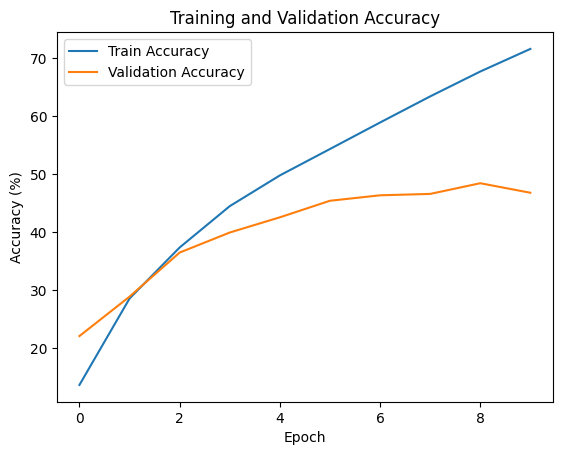

In [97]:
# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Train the model
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(trainloader)
    epoch_train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(valloader)
    epoch_val_accuracy = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%, '
          f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.2f}%')

print('Finished Training')

# Test the model
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Calculate test accuracy
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_loss /= len(testloader)
test_accuracy = 100 * correct_test / total_test

print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss, test_accuracy))

# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot accuracy curves
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [99]:
# Evaluate the model
model.eval()
y_true = []
y_pred_classes = []

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred_classes.extend(predicted.cpu().numpy())


# Calculate evaluation metrics
import numpy as np
y_true = np.array(y_true)
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
f1 = f1_score(y_true, y_pred_classes, average='macro')

print("Accuracy:", accuracy*100)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 47.79
Precision: 0.5204481879506034
Recall: 0.4779
F1 Score: 0.4795593827787532


We can clearly see increasing accuarcy after adding residual blocks but from accuracy and also visualization.


Residual blocks are used in deep neural network architectures, including convolutional neural networks (CNNs), to address the problem of vanishing gradients and facilitate the training of very deep networks.

In our architecture, if we add residual blocks, we're essentially introducing skip connections that enable the gradient to flow more directly through the network during backpropagation. This helps in mitigating the vanishing gradient problem, especially in very deep networks, where gradients tend to diminish as they propagate backward through many layers, making it difficult to update the parameters of early layers effectively.